In [1]:
import datetime, warnings, scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import date
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
# from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('sample_Flights_Delay_clean.csv')

In [3]:
df.head()

,AIRLINE,ABBR_AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SD_MONTH,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY,TOTAL_DELAY_MIN,DELAY
0,US,US Airways Inc.,PHX,EWR,2133,1,1/23/2015 9:45,1/23/2015 9:43,-2,1/23/2015 16:22,1/23/2015 16:21,-1,16,959,255,1614,7,278,277,-1 days +23:59:00.000000000,-1,0
1,WN,Southwest Airlines Co.,PDX,SMF,479,9,9/20/2015 13:05,9/20/2015 13:00,-5,9/20/2015 14:30,9/20/2015 14:26,-4,11,1311,70,1421,5,86,85,-1 days +23:56:00.000000000,-4,0
2,AS,Alaska Airlines Inc.,FLL,SEA,2717,7,7/3/2015 18:45,7/3/2015 18:41,-4,7/3/2015 22:03,7/3/2015 22:13,10,13,1854,360,2154,19,392,378,0 days 00:10:00.000000000,10,1
3,DL,Delta Air Lines Inc.,MCO,ATL,404,8,8/21/2015 14:30,8/21/2015 14:29,-1,8/21/2015 16:15,8/21/2015 15:52,-23,13,1442,65,1547,5,83,105,-1 days +23:37:00.000000000,-23,0
4,OO,Skywest Airlines Inc.,SBA,PHX,455,1,1/11/2015 19:20,1/11/2015 20:01,41,1/11/2015 21:47,1/11/2015 22:20,33,8,2009,66,2215,5,79,87,0 days 00:33:00.000000000,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236662 entries, 0 to 236661
Data columns (total 22 columns):
AIRLINE                236662 non-null object
ABBR_AIRLINE           236662 non-null object
ORIGIN_AIRPORT         236662 non-null object
DESTINATION_AIRPORT    236662 non-null object
DISTANCE               236662 non-null int64
SD_MONTH               236662 non-null int64
SCHEDULED_DEPARTURE    236662 non-null object
DEPARTURE_TIME         236662 non-null object
DEPARTURE_DELAY        236662 non-null int64
SCHEDULED_ARRIVAL      236662 non-null object
ARRIVAL_TIME           236662 non-null object
ARRIVAL_DELAY          236662 non-null int64
TAXI_OUT               236662 non-null int64
WHEELS_OFF             236662 non-null int64
AIR_TIME               236662 non-null int64
WHEELS_ON              236662 non-null int64
TAXI_IN                236662 non-null int64
ELAPSED_TIME           236662 non-null int64
SCHEDULED_TIME         236662 non-null int64
TOTAL_DELAY            236

In [5]:
df['SCHEDULED_DEPARTURE'] = pd.to_datetime(df['SCHEDULED_DEPARTURE'])
df['DEPARTURE_TIME'] = pd.to_datetime(df['DEPARTURE_TIME'])
df['SCHEDULED_ARRIVAL'] = pd.to_datetime(df['SCHEDULED_ARRIVAL'])
df['ARRIVAL_TIME'] = pd.to_datetime(df['ARRIVAL_TIME'])

# Feature Engineering
Mengubah menjadi day, month, dan hour feature, dari semua timestamp menjadi feature (SCHEDULED_DEPARTURE, DEPARTURE_TIME, SCHEDULED_ARRIVAL, ARRIVAL_TIME)

In [6]:
df['SD_DAY'] = df['SCHEDULED_DEPARTURE'].dt.day
df['SD_HOUR'] = df['SCHEDULED_DEPARTURE'].dt.hour

df['DT_DAY'] = df['DEPARTURE_TIME'].dt.day
df['DT_MONTH'] = df['DEPARTURE_TIME'].dt.month
df['DT_HOUR'] = df['DEPARTURE_TIME'].dt.hour

df['SA_DAY'] = df['SCHEDULED_ARRIVAL'].dt.day
df['SA_MONTH'] = df['SCHEDULED_ARRIVAL'].dt.month
df['SA_HOUR'] = df['SCHEDULED_ARRIVAL'].dt.hour

df['AT_DAY'] = df['ARRIVAL_TIME'].dt.day
df['AT_MONTH'] = df['ARRIVAL_TIME'].dt.month
df['AT_HOUR'] = df['ARRIVAL_TIME'].dt.hour

In [7]:
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'DISTANCE','SD_DAY', 'SD_MONTH','SD_HOUR','DEPARTURE_DELAY',
       'SA_DAY','SA_MONTH','SA_HOUR', 'ARRIVAL_DELAY','TAXI_OUT', 'WHEELS_OFF',
       'AIR_TIME', 'WHEELS_ON', 'TAXI_IN','ELAPSED_TIME', 
       'SCHEDULED_TIME', 'TOTAL_DELAY', 'TOTAL_DELAY_MIN',
       'DELAY']]
df.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SD_DAY,SD_MONTH,SD_HOUR,DEPARTURE_DELAY,SA_DAY,SA_MONTH,SA_HOUR,ARRIVAL_DELAY,TAXI_OUT,WHEELS_OFF,AIR_TIME,WHEELS_ON,TAXI_IN,ELAPSED_TIME,SCHEDULED_TIME,TOTAL_DELAY,TOTAL_DELAY_MIN,DELAY
0,US,PHX,EWR,2133,23,1,9,-2,23,1,16,-1,16,959,255,1614,7,278,277,-1 days +23:59:00.000000000,-1,0
1,WN,PDX,SMF,479,20,9,13,-5,20,9,14,-4,11,1311,70,1421,5,86,85,-1 days +23:56:00.000000000,-4,0
2,AS,FLL,SEA,2717,3,7,18,-4,3,7,22,10,13,1854,360,2154,19,392,378,0 days 00:10:00.000000000,10,1
3,DL,MCO,ATL,404,21,8,14,-1,21,8,16,-23,13,1442,65,1547,5,83,105,-1 days +23:37:00.000000000,-23,0
4,OO,SBA,PHX,455,11,1,19,41,11,1,21,33,8,2009,66,2215,5,79,87,0 days 00:33:00.000000000,33,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236662 entries, 0 to 236661
Data columns (total 22 columns):
AIRLINE                236662 non-null object
ORIGIN_AIRPORT         236662 non-null object
DESTINATION_AIRPORT    236662 non-null object
DISTANCE               236662 non-null int64
SD_DAY                 236662 non-null int64
SD_MONTH               236662 non-null int64
SD_HOUR                236662 non-null int64
DEPARTURE_DELAY        236662 non-null int64
SA_DAY                 236662 non-null int64
SA_MONTH               236662 non-null int64
SA_HOUR                236662 non-null int64
ARRIVAL_DELAY          236662 non-null int64
TAXI_OUT               236662 non-null int64
WHEELS_OFF             236662 non-null int64
AIR_TIME               236662 non-null int64
WHEELS_ON              236662 non-null int64
TAXI_IN                236662 non-null int64
ELAPSED_TIME           236662 non-null int64
SCHEDULED_TIME         236662 non-null int64
TOTAL_DELAY            236662 n

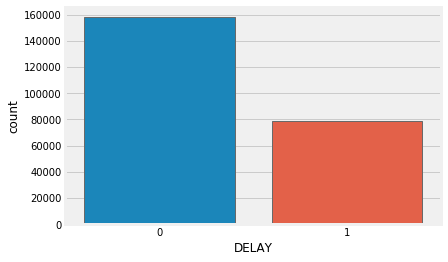

In [9]:
sns.countplot(x=df['DELAY'])

# Label Encoder bagi feature "AIRPORT" dan juga "AIRLINES" untuk nantinya dapat digunakan untuk model prediksi kita.

In [10]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

df[['ORIGIN_AIRPORT']] = label_encoder.fit_transform(df[['ORIGIN_AIRPORT']])

df['ORIGIN_AIRPORT'].unique()

array([534, 531, 409, 488, 566, 512, 429, 572, 367, 381, 427, 598, 401,
       346, 523, 581, 497, 315, 461, 564, 516, 477, 471, 490, 391, 530,
       552, 380, 469, 563,  78, 361,  21, 349, 399,  79, 416, 578, 589,
       446, 137, 459, 438,  72, 283, 376, 573, 297, 247, 317, 373, 355,
       208, 533, 334, 295, 465, 511, 500, 357, 464, 218, 515, 447, 362,
       466, 333, 498,  36, 499, 519, 614, 520, 509, 397, 492, 326, 345,
       548, 388,  47, 601, 359, 356,  60, 460, 379, 567, 179, 262, 368,
       574, 485, 508, 584, 582, 482, 363, 332, 452, 561, 405, 344, 556,
        19, 255, 354, 487,  16, 187, 395,  46, 425, 313,  75, 312, 311,
       413, 611, 457,  80, 342, 202, 517, 189,  86, 451, 347, 170, 387,
       199, 554, 331, 436, 205, 538, 448, 164, 270, 565, 222,  68, 479,
       279, 610, 444, 518, 503, 431, 348, 426, 576, 522, 474, 411, 246,
       577, 158, 266, 547, 318, 424, 377, 182, 603, 316, 489, 478, 542,
       166, 224, 440, 198, 472, 580, 493, 480, 260, 419, 450,  9

In [11]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

df[['DESTINATION_AIRPORT']] = label_encoder.fit_transform(df[['DESTINATION_AIRPORT']])

df['DESTINATION_AIRPORT'].unique()

array([400, 581, 571, 314, 533, 497, 580, 486, 380, 345, 343, 468, 376,
       572, 378, 352, 529, 354, 331, 408, 443, 460, 379, 583, 577, 562,
       296,  18, 537, 327, 532, 216, 487, 491, 143, 387, 449, 458, 372,
        76, 445, 489, 597, 155, 470, 563,  77, 519, 534, 437, 404, 333,
       424, 325, 320, 494, 496, 479, 274, 561, 511, 553, 522, 394, 435,
       514, 316, 264, 360, 476, 375, 611, 498, 510, 358, 262,  36, 311,
        78, 440, 517, 421, 521, 202, 104, 507, 396, 555, 454, 332, 530,
       344, 373,  46,  10, 588, 361, 601, 438, 119, 249, 275, 172, 564,
        20, 560, 295, 551, 338,  96, 502, 606, 516, 205, 247, 330, 442,
       552, 194, 591, 475, 161, 153, 451, 313, 243, 478, 425, 171, 459,
       557, 492, 508, 403, 261,  58, 579, 146, 336,  34, 294, 518, 121,
       353, 128, 298, 245, 415, 574, 386, 241, 464, 348, 481, 544, 204,
       183, 366, 469, 252, 610, 385, 308, 495, 409, 406,   2, 573, 482,
       546, 134, 600, 195, 368, 319, 488, 426,  84, 174, 556, 27

In [12]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

df['AIRLINE'] = label_encoder.fit_transform(df['AIRLINE'])

df['AIRLINE'].unique()

array([11, 13,  1,  3,  9,  0,  7, 10,  4,  2, 12,  6,  8,  5],
      dtype=int64)

# Random Forest

## 2 model Random Forest akan dibuat : 
### 1. Yang pertama untuk menentukan feature importance kepada target yaitu DELAY. 
### 2. Dan yang ke2 untuk kita coba dalam situasi nyata, dimana faktor atau feature yang diketahui akan digunakan ke dalam training dan test machine learning nantinya.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X = df.drop(['DELAY','TOTAL_DELAY','TOTAL_DELAY_MIN'],axis=1)
y  = df['DELAY']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,random_state=101)

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
from sklearn.model_selection import GridSearchCV

parameters = {
             'class_weight':[{0:1,1:5},{0:5,1:1},{0:1,1:2}],
             'max_depth':[10,20,15]
                }
rfc = RandomForestClassifier()
dt = GridSearchCV(rfc,parameters, scoring= 'recall',cv=5)
dt.fit(X_train,y_train)
dt.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 5},
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [18]:
rfc_1 = RandomForestClassifier(n_estimators =100)

In [19]:
rfc_1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Evaluasi Model untuk Feature Importance

In [20]:
from sklearn.metrics import classification_report,confusion_matrix,matthews_corrcoef, roc_auc_score, accuracy_score, roc_curve, auc,f1_score

In [21]:
predict = rfc_1.predict(X_test)
predictProb = rfc_1.predict_proba(X_test)

In [22]:
predict_tr = rfc_1.predict(X_train)
predictProb_tr = rfc_1.predict_proba(X_train)

In [23]:
print(classification_report(y_train,predict_tr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    149971
           1       1.00      1.00      1.00     74857

    accuracy                           1.00    224828
   macro avg       1.00      1.00      1.00    224828
weighted avg       1.00      1.00      1.00    224828



In [24]:
print('ROC AUC :', roc_auc_score(y_train, predictProb_tr[:,1]))
print('Accuracy :',accuracy_score(y_train, predict_tr))
print('Matthews Corr_coef :',matthews_corrcoef(y_train, predict_tr))

ROC AUC : 1.0
Accuracy : 1.0
Matthews Corr_coef : 1.0


In [25]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.68      0.95      0.80      7978
           1       0.45      0.08      0.14      3856

    accuracy                           0.67     11834
   macro avg       0.57      0.52      0.47     11834
weighted avg       0.61      0.67      0.58     11834



In [26]:
print('ROC AUC :', roc_auc_score(y_test, predictProb[:,1]))
print('Accuracy :',accuracy_score(y_test, predict))
print('Matthews Corr_coef :',matthews_corrcoef(y_test, predict))

ROC AUC : 0.5776328855337656
Accuracy : 0.6688355585600811
Matthews Corr_coef : 0.06761020323086


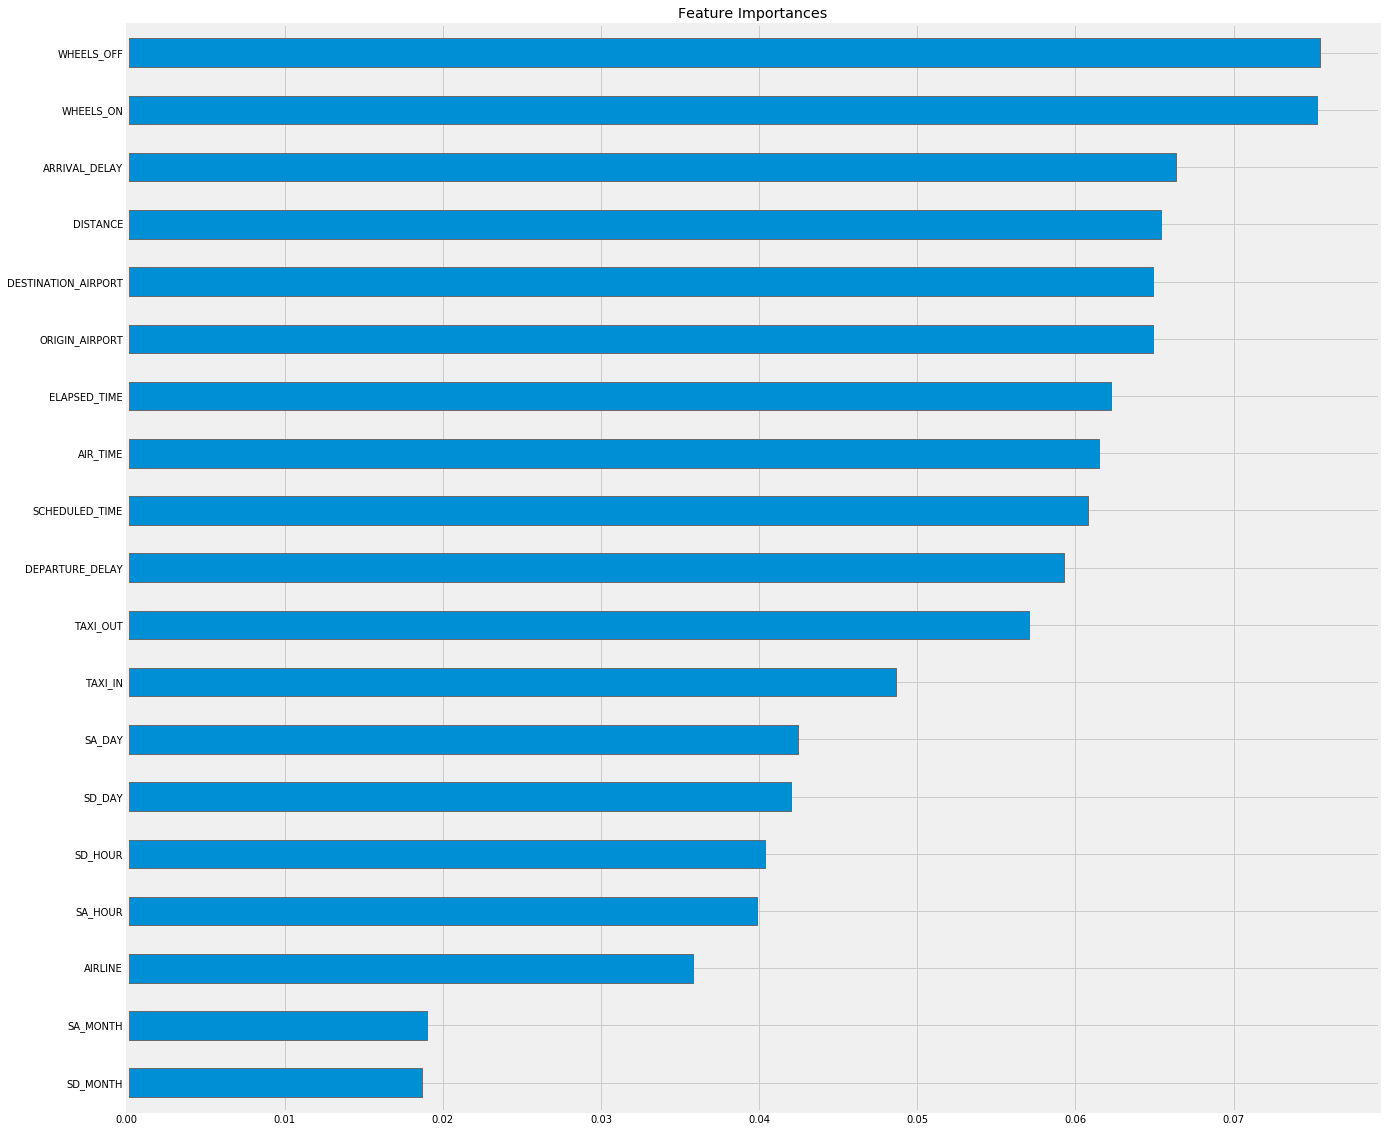

In [27]:
plt.figure(figsize =(20,20))
coef1 = pd.Series(rfc_1.feature_importances_, X_train.columns).sort_values(ascending = True)
coef1.plot(kind='barh', title='Feature Importances')

# Berdasarkan Feature Importance

## "WHEELS_OFF" & "WHEELS_ON" berada di posisi tertinggi, akan tetapi apabila kita menempatkan diri sebagai pelanggan maskapai, kita tidak akan tahu kapan terjadinya.

### Pengguna akan kesulitan dan tidak tertarik untuk menggunakan model prediksi.

## Maka Feature yang akan dipakai:
### 'AIRLINE' 
### 'ORIGIN_AIRPORT'
### 'DESTINATION_AIRPORT'
### 'DISTANCE'
### 'SD_DAY'
### 'SD_MONTH'
### 'SD_HOUR'
### 'SA_DAY'
### 'SA_MONTH'
### 'SA_HOUR'
### 'AIR_TIME'
### 'SCHEDULED_TIME'.

# Model testing untuk situasi real life bagi pengguna. 

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X =df.drop(['DELAY','TOTAL_DELAY','TOTAL_DELAY_MIN',
            'DEPARTURE_DELAY','ARRIVAL_DELAY',
            'TAXI_OUT','WHEELS_OFF','WHEELS_ON','TAXI_IN',
            'ELAPSED_TIME'
           ],axis=1)
y = df['DELAY']

In [30]:
X.columns

Index(['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DISTANCE',
       'SD_DAY', 'SD_MONTH', 'SD_HOUR', 'SA_DAY', 'SA_MONTH', 'SA_HOUR',
       'AIR_TIME', 'SCHEDULED_TIME'],
      dtype='object')

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=101)

# RFC 2 Train 

In [32]:
rfc_2 = RandomForestClassifier(n_estimators= 100,max_features=12,max_depth = 15, class_weight={0:1,1:2})

In [33]:
rfc_2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 2},
                       criterion='gini', max_depth=15, max_features=12,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

# Evaluasi RFC Model ke-2

In [34]:
from sklearn.metrics import classification_report,confusion_matrix,matthews_corrcoef, roc_auc_score, accuracy_score, roc_curve, auc,f1_score

In [35]:
predict_tr = rfc_2.predict(X_train)
predictProb_tr = rfc_2.predict_proba(X_train)

In [36]:
predict = rfc_2.predict(X_test)
predictProb = rfc_2.predict_proba(X_test)

In [37]:
print(classification_report(y_train,predict_tr))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84    110623
           1       0.66      0.78      0.71     55040

    accuracy                           0.79    165663
   macro avg       0.77      0.79      0.77    165663
weighted avg       0.80      0.79      0.79    165663



In [38]:
print('ROC AUC :', roc_auc_score(y_train, predictProb_tr[:,1]))
print('Accuracy :',accuracy_score(y_train, predict_tr))
print('Matthews Corr_coef :',matthews_corrcoef(y_train, predict_tr))

ROC AUC : 0.8772872984472824
Accuracy : 0.7905386235912666
Matthews Corr_coef : 0.5534999404612178


# RFC model ke 2 TESTING

In [39]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.71      0.70      0.71     47326
           1       0.42      0.44      0.43     23673

    accuracy                           0.61     70999
   macro avg       0.57      0.57      0.57     70999
weighted avg       0.62      0.61      0.61     70999



In [40]:
print('ROC AUC :', roc_auc_score(y_test, predictProb[:,1]))
print('Accuracy :',accuracy_score(y_test, predict))
print('Matthews Corr_coef :',matthews_corrcoef(y_test, predict))

ROC AUC : 0.5929452705835886
Accuracy : 0.6117269257313483
Matthews Corr_coef : 0.13512211772345592


In [41]:
X.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,SD_DAY,SD_MONTH,SD_HOUR,SA_DAY,SA_MONTH,SA_HOUR,AIR_TIME,SCHEDULED_TIME
0,11,534,400,2133,23,1,9,23,1,16,255,277
1,13,531,581,479,20,9,13,20,9,14,70,85
2,1,409,571,2717,3,7,18,3,7,22,360,378
3,3,488,314,404,21,8,14,21,8,16,65,105
4,9,566,533,455,11,1,19,11,1,21,66,87


### Precision adalah tingkat ketepatan antara informasi yang diminta oleh pengguna dengan jawaban yang diberikan oleh sistem. 
### Sedangkan recall adalah tingkat keberhasilan sistem dalam menemukan kembali sebuah informasi.
### ROC (Receiver Operating Characteristics) adalah alat ukur performance untuk classification, digunakan dalam menentukan threshold dari suatu model. 

# Feature Importance
### melihat feature -feature paling berpengaruh dalam model

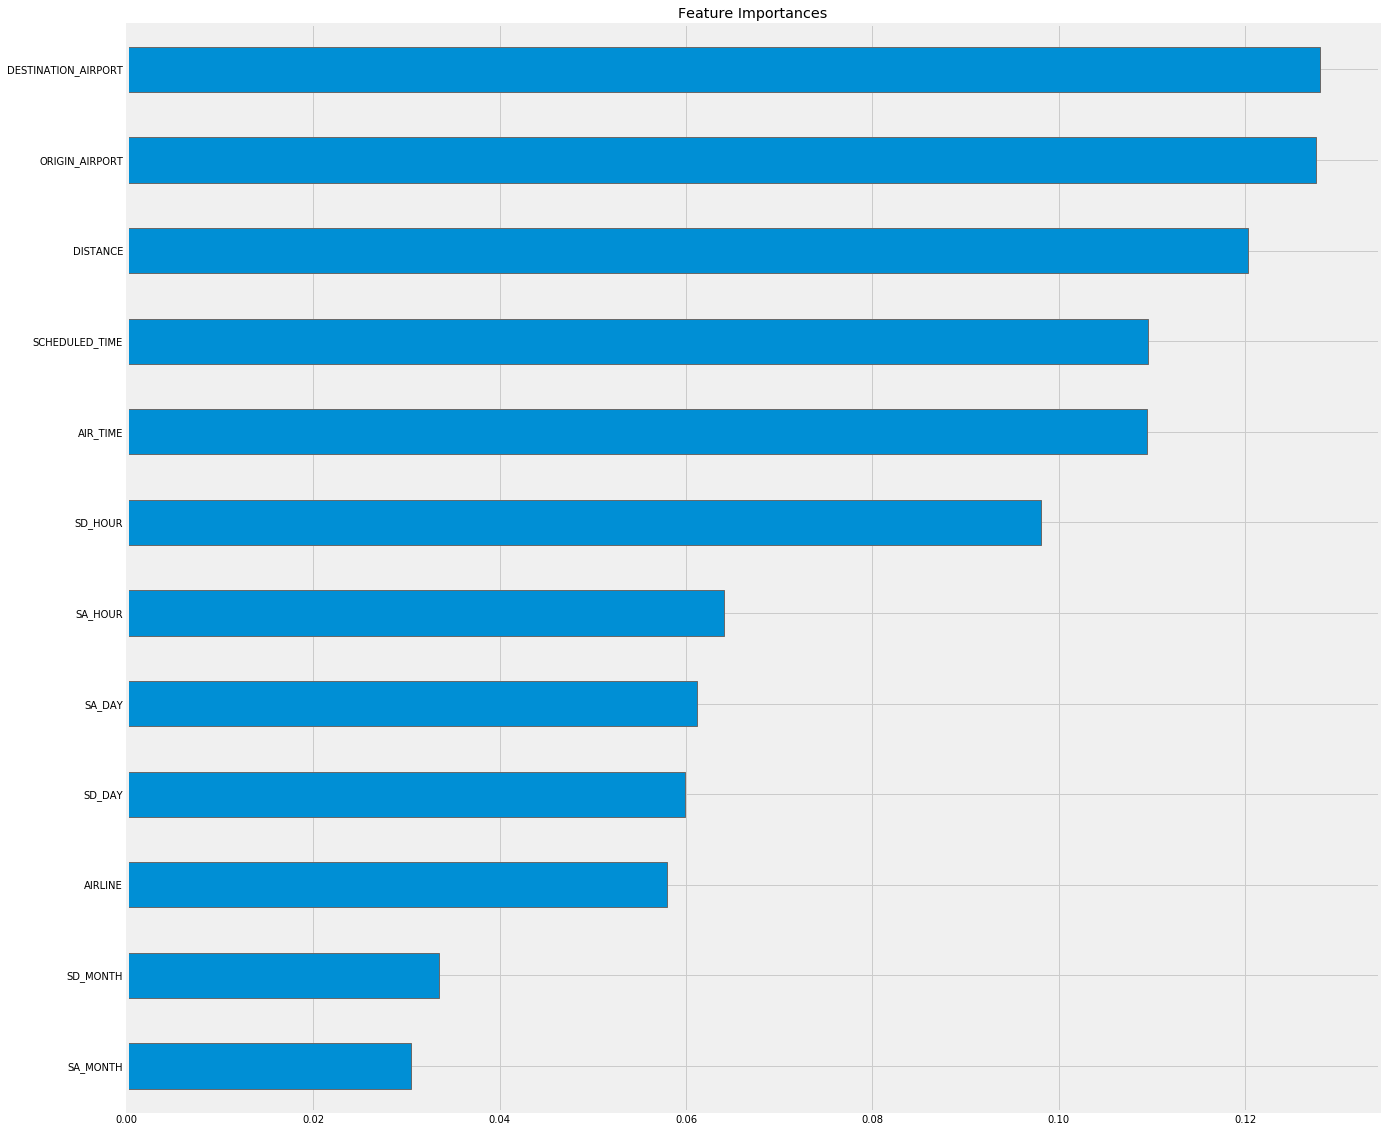

In [42]:
plt.figure(figsize =(20,20))
coef1 = pd.Series(rfc_2.feature_importances_, X_train.columns).sort_values(ascending = True)
coef1.plot(kind='barh', title='Feature Importances')

# Using K-Folds Cross-Validation

In [43]:
data =df.drop(['DELAY','TOTAL_DELAY','TOTAL_DELAY_MIN',
            'DEPARTURE_DELAY','ARRIVAL_DELAY',
            'TAXI_OUT','WHEELS_OFF','WHEELS_ON','TAXI_IN',
            'ELAPSED_TIME'
           ],axis=1)
target = df['DELAY']

In [44]:
data.shape

(236662, 12)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236662 entries, 0 to 236661
Data columns (total 12 columns):
AIRLINE                236662 non-null int32
ORIGIN_AIRPORT         236662 non-null int32
DESTINATION_AIRPORT    236662 non-null int32
DISTANCE               236662 non-null int64
SD_DAY                 236662 non-null int64
SD_MONTH               236662 non-null int64
SD_HOUR                236662 non-null int64
SA_DAY                 236662 non-null int64
SA_MONTH               236662 non-null int64
SA_HOUR                236662 non-null int64
AIR_TIME               236662 non-null int64
SCHEDULED_TIME         236662 non-null int64
dtypes: int32(3), int64(9)
memory usage: 19.0 MB


In [46]:
from sklearn.model_selection import KFold

K = 5
kf = KFold(n_splits=K, shuffle = True, random_state=42)

In [47]:
def calc_error(X, y, model):
    predictions = model.predict(X)
    predicProba = model.predict_proba(X)
    matt = matthews_corrcoef(y, predictions)
    f1 = f1_score(y, predictions, average='macro')
    report = classification_report(y, predictions)
    roc_auc = roc_auc_score(y, predicProba[:,1])
    accuracy = accuracy_score(y,predictions)
    con = pd.DataFrame(data=confusion_matrix(y,predictions),columns=['P No','P Yes'],index=['A No','A Yes'])
        
    return {
            'report':report,
            'matthew':matt,
            'f1':f1,
            'roc':roc_auc,
            'accuracy':accuracy,
            'confusion':con
            }

def calc_metrics(X_train,y_train,X_test,y_test, model):
    model.fit(X_train,y_train)
    train_error = calc_error(X_train,y_train, model)
    validation_error = calc_error(X_test,y_test, model)
    
    return train_error, validation_error

def value_in_kfold(data,scoring_type):
    a = []
    for i in range(K):
        a.append(data[i][scoring_type])
    return a

In [48]:
train_errors = []
validation_errors = []

for train_index, val_index in kf.split(data, target):
    
    # Split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    y_train, y_val = target.iloc[train_index], target.iloc[val_index]
    
    print(len(X_val),(len(X_train) + len(X_val)))
    
    # Instantite model
    model = rfc_2
    
    # Calculate Errors
    train_error, val_error = calc_metrics(X_train,y_train,X_val, y_val,model)
    
    train_errors.append(train_error)
    validation_errors.append(val_error)

47333 236662
47333 236662
47332 236662
47332 236662
47332 236662


In [49]:
acc = value_in_kfold(train_errors,'accuracy')
matt = value_in_kfold(train_errors,'matthew')
f1 = value_in_kfold(train_errors,'f1')
roc = value_in_kfold(train_errors,'roc')
con = value_in_kfold(train_errors,'confusion')
report = value_in_kfold(train_errors,'report')

In [50]:
acc_v = value_in_kfold(validation_errors,'accuracy')
matt_v = value_in_kfold(validation_errors,'matthew')
f1_v = value_in_kfold(validation_errors,'f1')
roc_v = value_in_kfold(validation_errors,'roc')
con_v = value_in_kfold(validation_errors,'confusion')
report_v = value_in_kfold(validation_errors,'report')

In [51]:
data_set = {'Train Acc':acc,
            'Test Acc':acc_v,
            'Train ROC AUC':roc,
            'Test ROC AUC':roc_v,
            'Train F1 Score':f1,
            'Test F1 Score':f1_v,
            'Train Matthews Corr Coef':matt,
            'Test Matthews Corr Coef':matt_v}

In [52]:
dfcc_result = pd.DataFrame(data_set)
dfcc_result

,Train Acc,Test Acc,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Matthews Corr Coef,Test Matthews Corr Coef
0,0.777292,0.604420,0.865728,0.591901,0.759689,0.562478,0.526673,0.125610
1,0.773336,0.605497,0.864443,0.594875,0.756171,0.565359,0.520505,0.132135
2,0.782391,0.608193,0.869592,0.597650,0.764826,0.565918,0.536029,0.132818
3,0.772857,0.606080,0.861451,0.592421,0.754623,0.564640,0.516003,0.130077
4,0.780658,0.610665,0.867384,0.595880,0.762345,0.567468,0.530608,0.135242


In [53]:
for item in data_set.keys():
    print('Average ' + str(item) +': ', np.mean(data_set[item]))

Average Train Acc:  0.7773068722640888
Average Test Acc:  0.6069711403829492
Average Train ROC AUC:  0.8657197556750976
Average Test ROC AUC:  0.594545619289174
Average Train F1 Score:  0.7595308475380955
Average Test F1 Score:  0.565172674064493
Average Train Matthews Corr Coef:  0.5259635590409723
Average Test Matthews Corr Coef:  0.1311763616084292


In [54]:
for n,item in enumerate(report):
    print(item)

              precision    recall  f1-score   support

           0       0.87      0.78      0.82    126419
           1       0.64      0.76      0.69     62910

    accuracy                           0.78    189329
   macro avg       0.75      0.77      0.76    189329
weighted avg       0.79      0.78      0.78    189329

              precision    recall  f1-score   support

           0       0.87      0.78      0.82    126302
           1       0.63      0.76      0.69     63027

    accuracy                           0.77    189329
   macro avg       0.75      0.77      0.76    189329
weighted avg       0.79      0.77      0.78    189329

              precision    recall  f1-score   support

           0       0.87      0.79      0.83    126244
           1       0.65      0.76      0.70     63086

    accuracy                           0.78    189330
   macro avg       0.76      0.78      0.76    189330
weighted avg       0.80      0.78      0.79    189330

              preci

In [55]:
for n,item in enumerate(report_v):
    print(item)

              precision    recall  f1-score   support

           0       0.71      0.69      0.70     31530
           1       0.41      0.44      0.43     15803

    accuracy                           0.60     47333
   macro avg       0.56      0.56      0.56     47333
weighted avg       0.61      0.60      0.61     47333

              precision    recall  f1-score   support

           0       0.72      0.68      0.70     31647
           1       0.41      0.46      0.43     15686

    accuracy                           0.61     47333
   macro avg       0.56      0.57      0.57     47333
weighted avg       0.62      0.61      0.61     47333

              precision    recall  f1-score   support

           0       0.72      0.69      0.70     31705
           1       0.41      0.45      0.43     15627

    accuracy                           0.61     47332
   macro avg       0.57      0.57      0.57     47332
weighted avg       0.62      0.61      0.61     47332

              preci

# Gradient Boosting

Membandingkan Gradient Boosting dan Random Forest

### Training Model 
Evaluasi kembali feature importance yang digunakan.

## Train Test Split

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
X =df.drop(['DELAY','TOTAL_DELAY','TOTAL_DELAY_MIN',
           ],axis=1)
y = df['DELAY']

In [58]:
X.dtypes

AIRLINE                int32
ORIGIN_AIRPORT         int32
DESTINATION_AIRPORT    int32
DISTANCE               int64
SD_DAY                 int64
SD_MONTH               int64
SD_HOUR                int64
DEPARTURE_DELAY        int64
SA_DAY                 int64
SA_MONTH               int64
SA_HOUR                int64
ARRIVAL_DELAY          int64
TAXI_OUT               int64
WHEELS_OFF             int64
AIR_TIME               int64
WHEELS_ON              int64
TAXI_IN                int64
ELAPSED_TIME           int64
SCHEDULED_TIME         int64
dtype: object

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

In [60]:
from xgboost import XGBClassifier

In [61]:
xgb_1 = XGBClassifier(learning_rate=0.1)

In [62]:
xgb_1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [63]:
from sklearn.metrics import classification_report,confusion_matrix,matthews_corrcoef, roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc,f1_score

In [64]:
predict = xgb_1.predict(X_test)
predictProb = xgb_1.predict_proba(X_test)

In [65]:
predict_tr = xgb_1.predict(X_train)
predictProb_tr = xgb_1.predict_proba(X_train)

In [66]:
print(classification_report(y_train,predict_tr))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80    110623
           1       0.62      0.01      0.03     55040

    accuracy                           0.67    165663
   macro avg       0.65      0.50      0.41    165663
weighted avg       0.65      0.67      0.54    165663



In [67]:
print('ROC AUC :', roc_auc_score(y_train, predictProb_tr[:,1]))
print('Accuracy :',accuracy_score(y_train, predict_tr))
print('Matthews Corr_coef :',matthews_corrcoef(y_train, predict_tr))

ROC AUC : 0.6025424659004478
Accuracy : 0.6694796061884669
Matthews Corr_coef : 0.05184200663195703


In [68]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80     47326
           1       0.57      0.01      0.02     23673

    accuracy                           0.67     70999
   macro avg       0.62      0.50      0.41     70999
weighted avg       0.63      0.67      0.54     70999



In [69]:
print('ROC AUC :', roc_auc_score(y_test, predictProb[:,1]))
print('Accuracy :',accuracy_score(y_test, predict))
print('Matthews Corr_coef :',matthews_corrcoef(y_test, predict))

ROC AUC : 0.5985423415582909
Accuracy : 0.667516443893576
Matthews Corr_coef : 0.041670305976768185


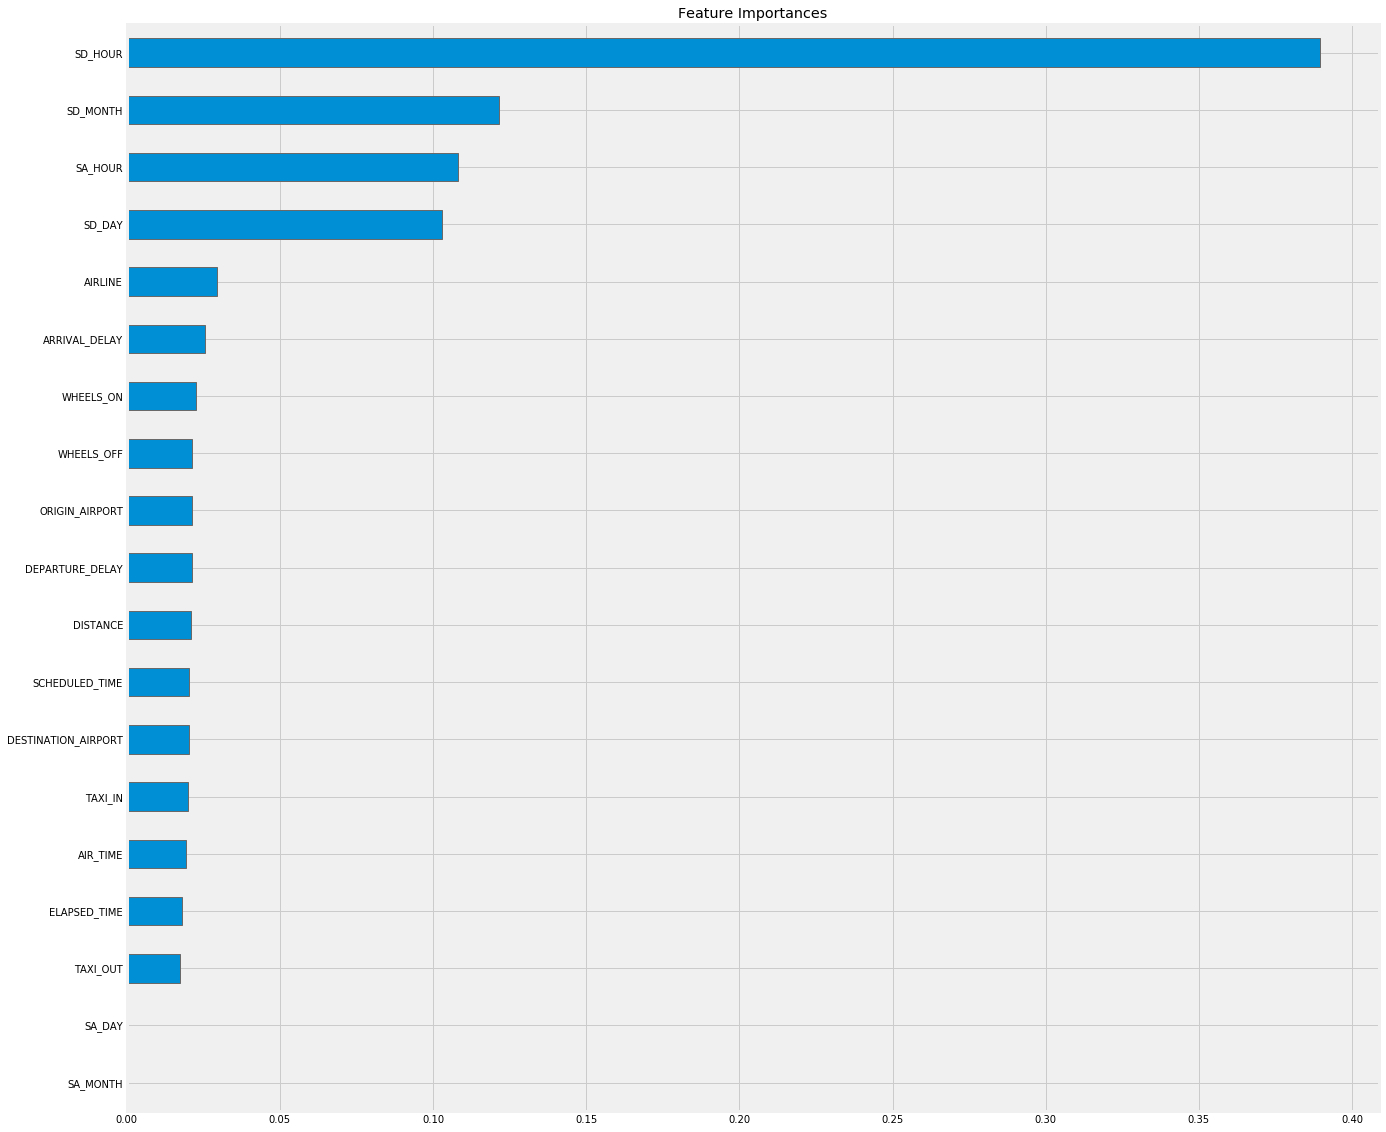

In [70]:
plt.figure(figsize =(20,20))
coef1 = pd.Series(xgb_1.feature_importances_, X_train.columns).sort_values(ascending = True)
coef1.plot(kind='barh', title='Feature Importances')

# Hasil pengecekan Feature Importance Model Gradient Boosting justru menunjukkan performa yang lebih buruk daripada Random Forest, walau memiliki tingkat accuracy sedikit lebih baik. 
# Akan tetapi Random Forest akan dipilih karna memiliki hasil feature importance yang lebih balance untuk itu "Random Forest" adalah model yang akan digunakan.

### ----------------------------------------------------------------------------------------------------------------------------

# Kesimpulan : 
## Dengan model machine learning dapat mempermudah dalam prediksi sebuah penerbangan akan terkena delay ataupun tidak.
## Bila dapat diprediksi, mempermudah pihak maskapai, bandara, maupun staff untuk menyiapkan prosedur operasional yang harus dilaksanakan, untuk menghindari keterlambatan lebih lama
## Bagi pengguna, apabila dapat memprediksi delaynya pesawat. Pengguna dapat memanfaatkan dan mengatur kembali jadwal maupun waktunya yang berharga, ataupun  aware terhadap hak -hak pengguna penerbangan yang bisa didapatkan.

In [71]:
# rfc_2.predict([[ 	DISTANCE 	SD_DAY 	SD_MONTH 	SD_HOUR 	SA_DAY 	SA_MONTH 	SA_HOUR 	AIR_TIME 	SCHEDULED_TIME]])
# rfc_2.predict_proba([[ 	DISTANCE 	SD_DAY 	SD_MONTH 	SD_HOUR 	SA_DAY 	SA_MONTH 	SA_HOUR 	AIR_TIME 	SCHEDULED_TIME]])

predict = (rfc_2.predict([[ 0, 309,  82, 1489, 27, 7, 12, 27, 7, 18, 188, 205 ]]))
predictProb = rfc_2.predict_proba([[ 0, 309,  82, 1489, 27, 7, 12, 27, 7, 18, 188, 205 ]])
print(round(np.max(predictProb) *100, 2 ), '%', predict)

58.04 % [0]


In [72]:
import joblib
filename = 'flight_rfc_model_revisi.sav';
joblib.dump(rfc_2, open(filename, 'wb'))